# IBM Data Science Professional Certification Project
This notebook outlines the codes I used for my final project.  
I also include some explanations which I hope would be helpful.    
There is also a blogpost which presents the work in a less technical way.
Feel free to [contact me](https://www.linkedin.com/in/leonardo-iheme/) if you have any questions.  
July 2019  

**By:**  
### Leonardo O. Iheme

The aim of the project was to investigate how two of Istanbul's most loved neighborhoods are related given the number of coffee shops, population, socio-economic status and other factors.  
It will be useful to any visitor or resident looking to explore the coffee habits of these neigborhoods.

In [1]:
# Import the necessary libraries

# web related
from bs4 import BeautifulSoup # web scraping tool
import requests # for making web requests

# Data manipulation
import pandas as pd # for data wrangling and organizing
import numpy as np # numerical computing
import re # regular expressions
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Machine learning
from sklearn.cluster import KMeans # import k-means for clustering stage

# visualization
from matplotlib import pyplot as plt
import folium # map rendering library
import seaborn as sns

sns.set()
%matplotlib inline

# Data acquisition

In [2]:
# Source of list of neighborhoods and postal codes
besiktas = requests.get(r"https://www.bulurum.com/en/post-codes/besiktas/istanbul/").text
kadikoy = requests.get(r"https://www.bulurum.com/en/post-codes/kadikoy/istanbul/").text

In [3]:
# Create a BeautifulSoup instance
b_soup = BeautifulSoup(besiktas)
k_soup = BeautifulSoup(kadikoy)

In [4]:
# Extract the table from the 'soup' instance after inspecting the webpage
b_Places = [place.text.split()[-1] for place in b_soup.find_all('td', class_='repeaterCellLeft address')]
b_Post_codes = [code.text for code in b_soup.find_all('td', class_='repeaterCell tk')]

k_Places = [place.text.split()[-1] for place in k_soup.find_all('td', class_='repeaterCellLeft address')]
k_Post_codes = [code.text for code in k_soup.find_all('td', class_='repeaterCell tk')]

b_neighborhood = [place.text.rsplit(' ', 1)[0] for place in b_soup.find_all('td', class_='repeaterCellLeft address')]
k_neighborhood = [place.text.rsplit(' ', 1)[0] for place in k_soup.find_all('td', class_='repeaterCellLeft address')]

In [5]:
# Create the data frame for analysis
df_places = pd.DataFrame()
df_places['Post_codes'] = b_Post_codes + k_Post_codes
df_places['Borough'] = b_Places + k_Places
df_places['Neighborhood'] = b_neighborhood + k_neighborhood

df = pd.DataFrame(df_places.groupby(['Post_codes', 'Borough'])['Neighborhood'].sum())#rsplit(', ')
df.reset_index(level=df.index.names, inplace=True)

# Use regular expressions to separate the neigborhoods by a comma, period and space
df['Neighborhood'] = [i.replace('.', '., ')[:-2] for i in list(df.Neighborhood.values)]
df.head()

,Post_codes,Borough,Neighborhood
0,34022,ABBASAĞA,"ABBASAĞA MAH., CIHANNUMA MAH., SİNANPAŞA MAH."
1,34330,LEVENT,"KONAKLAR MAH., LEVENT MAH."
2,34335,AKATLAR,AKAT MAH.
3,34337,ETİLER,ETİLER MAH.
4,34340,LEVAZIM,"KÜLTÜR MAH., LEVAZIM MAH., NİSBETİYE MAH., ULU..."


In [6]:
# This file was created while I worked on the rough version of the notebook
coffee_shops_population = pd.read_csv(r'coffee_shops_population.csv', index_col=0)

### Get Latitude and Longitude from google maps api
This information will be helpful when visualizing the neighborhoods on folium map

In [7]:
# obtain latitude and longitude information and add to dataframe
import googlemaps
gmaps = googlemaps.Client(key='****************************************')
# Geocoding the addresses
latitude = []
longitude = []
for x in coffee_shops_population.itertuples():
    geocode_result = gmaps.geocode(f'{x.Neighborhood}, Istanbul')
    # concatenate the latitudes and longitudes
    latitude = latitude + [geocode_result[0]['geometry']['location']['lat']]
    longitude = longitude + [(geocode_result[0]['geometry']['location']['lng'])]

# Add the latitudes and longitudes to the dataframe
coffee_shops_population['Latitude'] = latitude
coffee_shops_population['Longitude'] = longitude
coffee_shops_population.head()

,Neighborhood,District,HouseRent(sqm),Population,# Coffee shops,WalkToSeaside(min),Latitude,Longitude,PeoplePerCoffeeShop
0,19 MAYIS MAH.,Kadikoy,16,30310,8,38,41.058931,28.992160,3788.750000
1,ABBASAGA MAH.,Besiktas,23,5288,7,15,41.048010,29.004528,755.428571
2,CIHANNUMA MAH.,Besiktas,24,3898,25,11,41.046957,29.009117,155.920000
3,SINANPASA MAH.,Besiktas,24,2534,8,5,41.043099,29.004656,316.750000
4,ACIBADEM MAH.,Kadikoy,18,30549,6,30,41.002136,29.038719,5091.500000


### Create a map showing the neighborhoods we will work with

In [8]:
# create map of Istanbul showing the two districts
latitude, longitude = 41.0082, 28.9784
map_istanbul = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, district, neighbourhood in zip(coffee_shops_population['Latitude'], coffee_shops_population['Longitude'], coffee_shops_population['District'], coffee_shops_population['Neighborhood']):
    label = f'{neighbourhood}, {district}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_istanbul)  
map_istanbul.save(outfile= 'neighborhoods.html')   
map_istanbul

### Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = '*************************************************' # your Foursquare ID
CLIENT_SECRET = '*********************************************' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 1000000# limit of number of venues returned by Foursquare API

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    '''Function to get nearby venues'''
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue ID',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

#### Get the venues in the neighborhoods

In [11]:
b_k_venues = getNearbyVenues(names=coffee_shops_population['Neighborhood'],
                                   latitudes=coffee_shops_population['Latitude'],
                                   longitudes=coffee_shops_population['Longitude']
                                  )
b_k_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,19 MAYIS MAH.,41.058931,28.99216,Yogatime,4cab4d4344a8224b3db52c40,41.056785,28.986874,Yoga Studio
1,19 MAYIS MAH.,41.058931,28.99216,Victoria's Secret,4f5100b9e4b0b5f9a5bb7b90,41.063281,28.992400,Lingerie Store
2,19 MAYIS MAH.,41.058931,28.99216,Atatürk Müzesi,4cb87651035d236af42dcd4e,41.056357,28.986967,History Museum
3,19 MAYIS MAH.,41.058931,28.99216,Hümaliva Çikolata & Kahve,55bcf47d498e08d9c9742a5b,41.053195,28.993723,Chocolate Shop
4,19 MAYIS MAH.,41.058931,28.99216,Match Cafe,4b5c7a03f964a520b03129e3,41.065213,28.995525,Bistro


#### Get only the coffee shops and cafes

In [12]:
# Extract the coffee shops/cafes
b_k_coffees = b_k_venues[(b_k_venues['Venue Category']=='Coffee Shop') | (b_k_venues['Venue Category']=='Café')].reset_index(drop = True)
b_k_coffees.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,19 MAYIS MAH.,41.058931,28.99216,You Cafe & Butik,57b87d84498e007ab9e73a9d,41.052900,28.992739,Café
1,19 MAYIS MAH.,41.058931,28.99216,Starbucks,58e20635a37d7208fd238752,41.051722,28.992980,Coffee Shop
2,19 MAYIS MAH.,41.058931,28.99216,Mura Coffee,5b8ff55dc47cf9002c5f5ce7,41.050717,28.995441,Coffee Shop
3,19 MAYIS MAH.,41.058931,28.99216,KuruKahveci Fuat bey,568cc294498e88f975b5366f,41.066926,28.996887,Coffee Shop
4,19 MAYIS MAH.,41.058931,28.99216,Kafital Coffee Roastery,5981df05610f044b4e110178,41.050422,28.984988,Coffee Shop


In [13]:
# How many coffee shops are there in each neighborhood?
b_k_num_shops = b_k_coffees.groupby('Neighborhood').count().reset_index()[['Neighborhood', 'Venue']]
b_k_num_shops.columns = ['Neighborhood', '# Coffee shops']
b_k_num_shops.head()

,Neighborhood,# Coffee shops
0,19 MAYIS MAH.,8
1,ABBASAGA MAH.,7
2,ACIBADEM MAH.,25
3,AKATLAR MAH.,8
4,ARNAVUTKOY MAH.,6


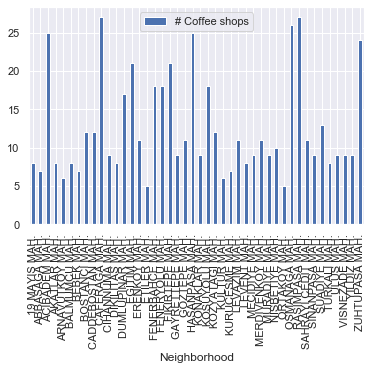

In [14]:
# Number of coffee shops in each neighborhood
b_k_num_shops.plot(x='Neighborhood', y='# Coffee shops', kind='bar');

In [15]:
# Number of coffee shops per neighborhood
coffee_shops_population['# Coffee shops'] = b_k_num_shops['# Coffee shops']
coffee_shops_population.head()

,Neighborhood,District,HouseRent(sqm),Population,# Coffee shops,WalkToSeaside(min),Latitude,Longitude,PeoplePerCoffeeShop
0,19 MAYIS MAH.,Kadikoy,16,30310,8,38,41.058931,28.992160,3788.750000
1,ABBASAGA MAH.,Besiktas,23,5288,7,15,41.048010,29.004528,755.428571
2,CIHANNUMA MAH.,Besiktas,24,3898,25,11,41.046957,29.009117,155.920000
3,SINANPASA MAH.,Besiktas,24,2534,8,5,41.043099,29.004656,316.750000
4,ACIBADEM MAH.,Kadikoy,18,30549,6,30,41.002136,29.038719,5091.500000


#### We can estimate the number of customers per coffee shop

In [16]:
# Estimate number of people per coffee shop and add to the dataframe then save it.
coffee_shops_population['PeoplePerCoffeeShop'] = coffee_shops_population['Population'] / coffee_shops_population['# Coffee shops']
coffee_shops_population.head()

,Neighborhood,District,HouseRent(sqm),Population,# Coffee shops,WalkToSeaside(min),Latitude,Longitude,PeoplePerCoffeeShop
0,19 MAYIS MAH.,Kadikoy,16,30310,8,38,41.058931,28.992160,3788.750000
1,ABBASAGA MAH.,Besiktas,23,5288,7,15,41.048010,29.004528,755.428571
2,CIHANNUMA MAH.,Besiktas,24,3898,25,11,41.046957,29.009117,155.920000
3,SINANPASA MAH.,Besiktas,24,2534,8,5,41.043099,29.004656,316.750000
4,ACIBADEM MAH.,Kadikoy,18,30549,6,30,41.002136,29.038719,5091.500000


#### Finally lets see the basic statistics of the dataframe

In [17]:
coffee_shops_population.describe()

,HouseRent(sqm),Population,# Coffee shops,WalkToSeaside(min),Latitude,Longitude,PeoplePerCoffeeShop
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,22.909091,14475.000000,12.568182,22.318182,41.026343,29.034612,1494.826933
std,5.116404,10060.739575,6.542874,14.806932,0.041902,0.026788,1332.313211
min,15.000000,2534.000000,5.000000,1.000000,40.958317,28.992160,144.037037
25%,18.000000,6209.500000,8.000000,10.000000,40.987701,29.014532,443.235931
50%,23.000000,11504.000000,9.500000,20.000000,41.045028,29.031264,980.409722
75%,27.000000,19358.000000,17.250000,32.750000,41.062030,29.049266,1917.916667
max,35.000000,35260.000000,27.000000,60.000000,41.093440,29.100420,5091.500000


# Comparing the Districts
## Exploratory Analysis

### 1. Averages

In [20]:
b_vs_k = coffee_shops_population.groupby("District", as_index=False).mean().drop(['Latitude', 'Longitude'],axis=1)
b_vs_k

,District,HouseRent(sqm),Population,# Coffee shops,WalkToSeaside(min),PeoplePerCoffeeShop
0,Besiktas,26.739130,8062.913043,13.086957,21.565217,790.679137
1,Kadikoy,18.714286,21497.761905,12.000000,23.142857,2266.036424


### 2. Population

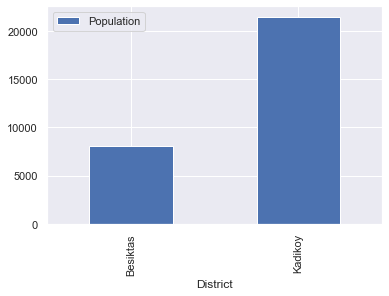

In [21]:
b_vs_k.plot(x='District', y='Population', kind='bar');

#### Observations

* Even though Kadikoy has a much higher population than Besiktas, both neighborhoods have around the same average number of coffee shops per neighborhood. There must be a higher coffee shop density in Besiktas but according to the number of people per coffee shop, this is not the case

### 3. Number of coffee shops

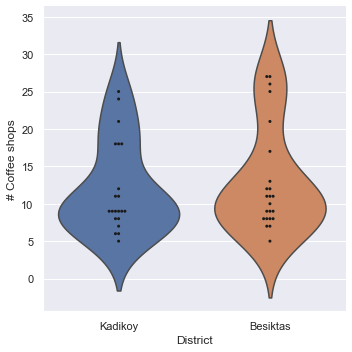

In [22]:
# Plot the house rent distribution in both districts
g = sns.catplot(x="District", y="# Coffee shops", kind="violin", inner=None, data=coffee_shops_population)
sns.swarmplot(x="District", y="# Coffee shops", color="k", size=3, data=coffee_shops_population, ax=g.ax);

#### Observations
* As seen from the table of averages, both districs have an almost equal number of coffee shops. We can also see that the variation in the number of coffee shops per neighborhood in both districs is almost eqal as well 

### 4. Price of rent

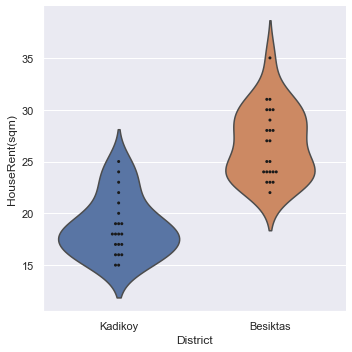

In [23]:
# Plot the house rent distribution in both districts
g = sns.catplot(x="District", y="HouseRent(sqm)", kind="violin", inner=None, data=coffee_shops_population)
sns.swarmplot(x="District", y="HouseRent(sqm)", color="k", size=3, data=coffee_shops_population, ax=g.ax);

#### Observations
* It costs more to rent in Besiktas than in Kadikoy. Although, the price of rent varies more across the neighborhoods in Kadikoy. This can be seen from the wide shape of the violin plot.

#### Breakdown of rent and # of coffee shops

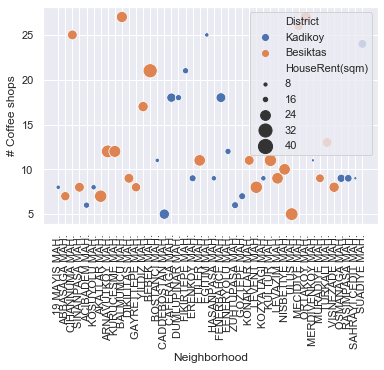

In [24]:
sns.scatterplot(x="Neighborhood", y="# Coffee shops",
                     hue="District", size="HouseRent(sqm)",
                     sizes=(10, 200),
                     data=coffee_shops_population)
plt.xticks(rotation=90)
sns.set(rc={'figure.figsize':(14,8)})

#### Observations
* We can see the interesting neighborhoods, that is those that stand out in their districts. For instance, Fenerbahce is the most expensive neighborhood in Kadikoy and it has the most number of coffee shops. Another interesting neighborhood is Egitim Mah. With cheap rent and a lot of coffee shops. In general, Kadikoy seems to be a more diverse district than Besiktas.

### Distance to the seaside
Let us examine the correlation between the distance to the seaside and the price of rent. We expect a positive corelation but let's confirm with a **regression plot**

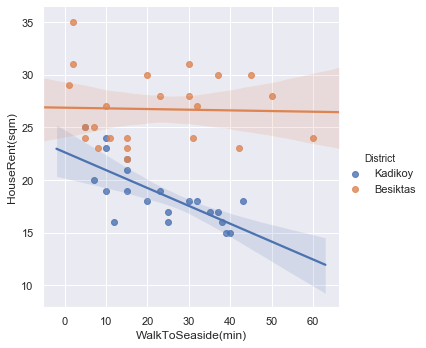

In [25]:
# District	HouseRent(sqm)	Population	# Coffee shops	WalkToSeaside(min)	PeoplePerCoffeeShop
sns.lmplot(x="WalkToSeaside(min)", y="HouseRent(sqm)", hue="District", data=coffee_shops_population);

#### Observation
* This further confirms that Besiktas is a much more expensive district than Kadikoy. The regression plots however, tell us that rent in Kadikoy is more linearly correlated to the distance from the sea than it is in Besiktas.

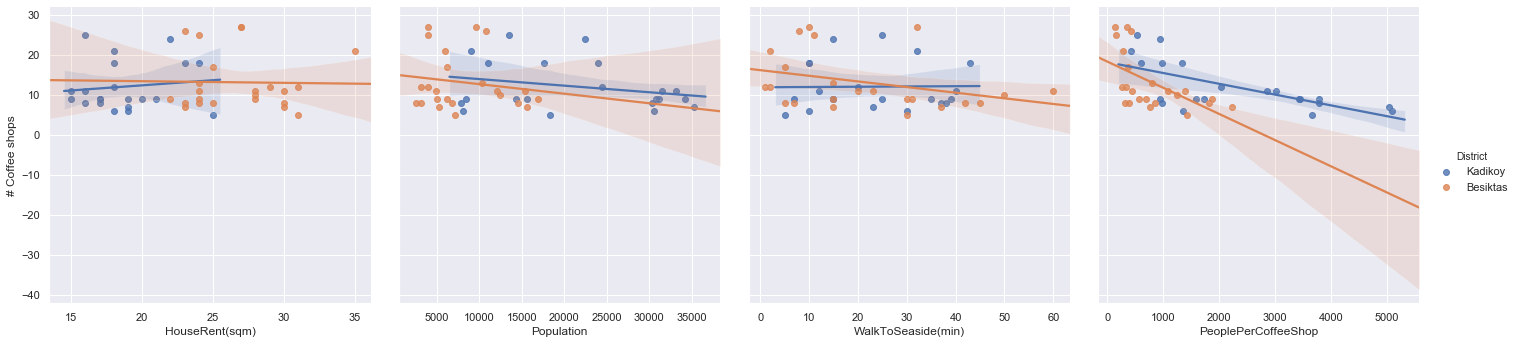

In [26]:
sns.pairplot(coffee_shops_population, x_vars=["HouseRent(sqm)", "Population", "WalkToSeaside(min)", "PeoplePerCoffeeShop"], y_vars=["# Coffee shops"],
             hue="District", height=5, aspect=1, kind="reg");

# Mapping the neigborhoods
Data Sources:  
* [House Rent](https://www.endeksa.com/en/)
* [Population](http://www.turkstat.gov.tr/VeriBilgi.do?alt_id=39)

#### Choropleth maps will give us a clearer picture of the numbers and charts that we have been discussing.

### Number of coffee shops in each neighborhood

In [27]:
b_k_coffee_map = folium.Map(tiles='cartodbpositron', location=[41.024897, 29.028609], zoom_start=11.5)

# geojson file
b_k_neighborhoods = 'b_k_neighborhoods.geojson'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(coffee_shops_population['# Coffee shops'].min(),
                              coffee_shops_population['# Coffee shops'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration


# generate choropleth map
b_k_coffee_map.choropleth(
    geo_data=b_k_neighborhoods,
    data=coffee_shops_population,
    columns=['Neighborhood', '# Coffee shops'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrBr',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name=r"Number of coffeeshops/cafes",
    reset=True,
    highlight=True
)
#b_k_coffee_map.save(outfile= 'b_k_coffee_map.html') 
b_k_coffee_map

### Population of each neighborhood

In [28]:
b_k_population_map = folium.Map(tiles='cartodbpositron', location=[41.024897, 29.028609], zoom_start=11.5)

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(coffee_shops_population['Population'].min(),
                              coffee_shops_population['Population'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# generate choropleth map
b_k_population_map.choropleth(
    geo_data=b_k_neighborhoods,
    data=coffee_shops_population,
    columns=['Neighborhood', 'Population'],
    key_on='feature.properties.neighborhood',
    fill_color='Blues',
    fill_opacity=0.6,
    line_opacity=0.4,
    legend_name=r"Population",
    threshold_scale=threshold_scale,
    reset=True,
    highlight=True
)
#b_k_population_map.save(outfile= 'b_k_population_map.html') 
b_k_population_map

### Average rental price of each neighborhood

In [29]:
b_k_rental_map = folium.Map(tiles='cartodbpositron', location=[41.024897, 29.028609], zoom_start=11.5)

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(coffee_shops_population['HouseRent(sqm)'].min(),
                              coffee_shops_population['HouseRent(sqm)'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# generate choropleth map
b_k_rental_map.choropleth(
    geo_data=b_k_neighborhoods,
    data=coffee_shops_population,
    columns=['Neighborhood', 'HouseRent(sqm)'],
    key_on='feature.properties.neighborhood',
    fill_color='OrRd',
    fill_opacity=0.6,
    line_opacity=0.4,
    legend_name=r"Rental price/sqm/Month",
    threshold_scale=threshold_scale,
    reset=True,
    highlight=True
)
#b_k_rental_map.save(outfile= 'b_k_rental_map.html') 
b_k_rental_map

### People per coffee shop

In [30]:
b_k_ppcs_map = folium.Map(tiles='cartodbpositron', location=[41.024897, 29.028609], zoom_start=11.5)

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(coffee_shops_population['PeoplePerCoffeeShop'].min(),
                              coffee_shops_population['PeoplePerCoffeeShop'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# generate choropleth map
b_k_ppcs_map.choropleth(
    geo_data=b_k_neighborhoods,
    data=coffee_shops_population,
    columns=['Neighborhood', 'PeoplePerCoffeeShop'],
    key_on='feature.properties.neighborhood',
    fill_color='Dark2',
    fill_opacity=0.6,
    line_opacity=0.4,
    legend_name=r"# People Per Coffee Shop",
    threshold_scale=threshold_scale,
    reset=True,
    highlight=True
)
#b_k_ppcs_map.save(outfile= 'b_k_ppcs_map.html')
b_k_ppcs_map

# Clustering Analysis

Run *k*-means to cluster the neighborhood into 5 clusters.

In [35]:
# set number of clusters
kclusters = 5

#Drop categorical variables
clustering = coffee_shops_population.drop(['Neighborhood', 'District', 'Latitude', 'Longitude'], 1)

# Normalizing over the standard deviation
from sklearn.preprocessing import StandardScaler
X = clustering.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 4, 2, 1, 3, 3, 2, 2, 4, 3, 3, 2, 4, 1, 1, 0, 3, 4, 1, 2, 4,
       3, 0, 0, 2, 1, 3, 3, 1, 2, 3, 3, 3, 4, 4, 1, 2, 2, 2, 2, 2, 1, 0])

In [36]:
# add clustering labels to the dataframe
coffee_shops_population["Cluster"] = kmeans.labels_
coffee_shops_population.head()

,Neighborhood,District,HouseRent(sqm),Population,# Coffee shops,WalkToSeaside(min),Latitude,Longitude,PeoplePerCoffeeShop,Cluster
0,19 MAYIS MAH.,Kadikoy,16,30310,8,38,41.058931,28.992160,3788.750000,1
1,ABBASAGA MAH.,Besiktas,23,5288,7,15,41.048010,29.004528,755.428571,2
2,CIHANNUMA MAH.,Besiktas,24,3898,25,11,41.046957,29.009117,155.920000,4
3,SINANPASA MAH.,Besiktas,24,2534,8,5,41.043099,29.004656,316.750000,2
4,ACIBADEM MAH.,Kadikoy,18,30549,6,30,41.002136,29.038719,5091.500000,1


In [37]:
# Show clusters on map
b_k_cluster_map = folium.Map(tiles='cartodbpositron', location=[41.024897, 29.028609], zoom_start=11.5)

# generate choropleth map
b_k_cluster_map.choropleth(
    geo_data=b_k_neighborhoods,
    data=coffee_shops_population,
    columns=['Neighborhood', 'Cluster'],
    key_on='feature.properties.neighborhood',
    fill_color='Set2',
    fill_opacity=0.6,
    line_opacity=0.4,
    legend_name=r"Similar Neigborhoods",
    reset=True,
    highlight=True
)
#b_k_cluster_map.save(outfile= 'b_k_cluster_map.html')
b_k_cluster_map

#### Examine cluster 4

In [38]:
coffee_shops_population[coffee_shops_population['Cluster']==4]

,Neighborhood,District,HouseRent(sqm),Population,# Coffee shops,WalkToSeaside(min),Latitude,Longitude,PeoplePerCoffeeShop,Cluster
2,CIHANNUMA MAH.,Besiktas,24,3898,25,11,41.046957,29.009117,155.920000,4
9,BALMUMCU MAH.,Besiktas,27,3889,27,32,41.059105,29.014714,144.037037,4
13,BEBEK MAH.,Besiktas,35,5891,21,2,41.077744,29.041629,280.523810,4
18,FIKIRTEPE MAH.,Kadikoy,18,9025,21,32,40.994303,29.050357,429.761905,4
21,EGİTIM MAH.,Kadikoy,16,13438,25,25,40.989668,29.050357,537.520000,4
34,MECIDIYE MAH.,Besiktas,23,10766,26,8,41.049973,29.020572,414.076923,4
35,ORTAKOY MAH.,Besiktas,27,9556,27,10,41.051468,29.027659,353.925926,4


In [39]:
coffee_shops_population['Cluster'] = coffee_shops_population.Cluster.astype('category')

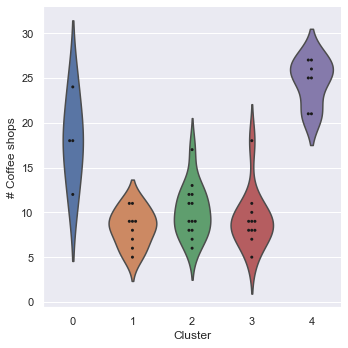

In [40]:
# Plot the # Coffee shops distribution each cluster
g = sns.catplot(x="Cluster", y="# Coffee shops", kind="violin", inner=None, data=coffee_shops_population)
sns.swarmplot(x="Cluster", y="# Coffee shops", color="k", size=3, data=coffee_shops_population, ax=g.ax);

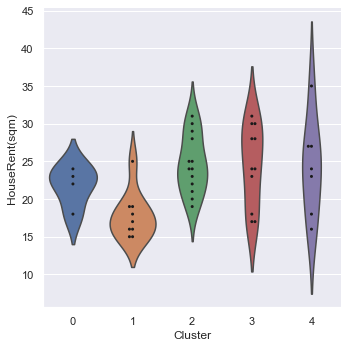

In [41]:
# Plot the HouseRent(sqm) distribution each cluster
g = sns.catplot(x="Cluster", y="HouseRent(sqm)", kind="violin", inner=None, data=coffee_shops_population)
sns.swarmplot(x="Cluster", y="HouseRent(sqm)", color="k", size=3, data=coffee_shops_population, ax=g.ax);

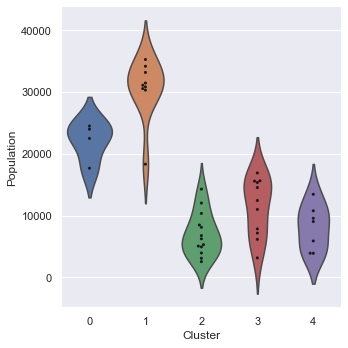

In [42]:
# Plot the Population distribution each cluster
g = sns.catplot(x="Cluster", y="Population", kind="violin", inner=None, data=coffee_shops_population)
sns.swarmplot(x="Cluster", y="Population", color="k", size=3, data=coffee_shops_population, ax=g.ax);

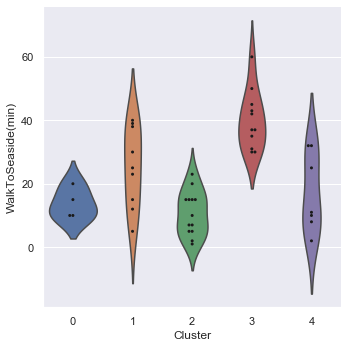

In [43]:
# Plot the WalkToSeaside(min) distribution each cluster
g = sns.catplot(x="Cluster", y="WalkToSeaside(min)", kind="violin", inner=None, data=coffee_shops_population)
sns.swarmplot(x="Cluster", y="WalkToSeaside(min)", color="k", size=3, data=coffee_shops_population, ax=g.ax);

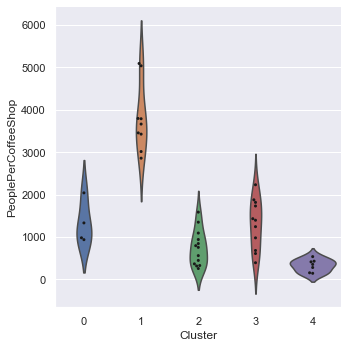

In [44]:
# Plot the People Per Coffee Shop distribution each cluster
g = sns.catplot(x="Cluster", y="PeoplePerCoffeeShop", kind="violin", inner=None, data=coffee_shops_population)
sns.swarmplot(x="Cluster", y="PeoplePerCoffeeShop", color="k", size=3, data=coffee_shops_population, ax=g.ax);

In [45]:
df_clusters = coffee_shops_population.drop(['Latitude', 'Longitude'], 1)

#### The plot shows a summary of the relatioshib between the features and how they are clustered

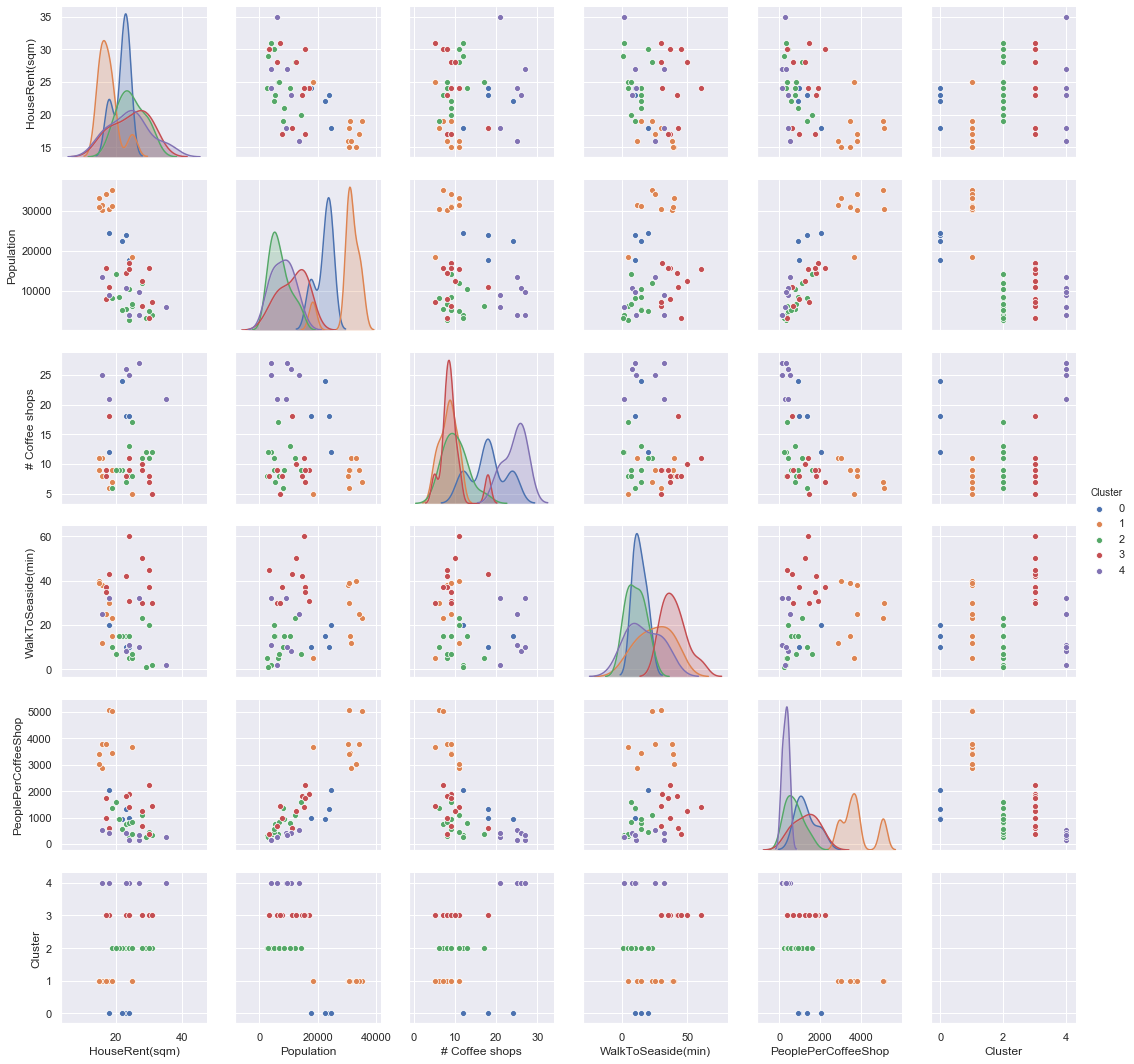

In [47]:
sns.pairplot(df_clusters, hue='Cluster')